# Step 1: Extract and merge walk graph and ferries graph
Extract the walk network via OSMNX within the AOI, add ferries to the network, and run advanced snapping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import Point

C:\Users\war-machine\anaconda3\envs\gostnets3_8\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
import os, sys

In [4]:
sys.path.append(r'C:\repos\GOSTnets')
import GOSTnets as gn

In [5]:
# configuring ferry as a useful tag
ox.utils.config(useful_tags_way= [
    "bridge",
    "tunnel",
    "oneway",
    "lanes",
    "ref",
    "name",
    "highway",
    "maxspeed",
    "service",
    "access",
    "area",
    "landuse",
    "width",
    "est_width",
    "junction",
    "ferry"
])

# Extract Walk network via OSMNX

In [6]:
# import extent
cap_haitian_extent = gpd.read_file(r"C:\repos\GOST_PublicGoods\Implementations\FY21\ACC_GTFS_accessibility_analysis_Cap_Haitien_Haiti\input_folder\poverty_survey_area.shp")

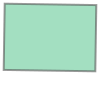

In [7]:
extent = cap_haitian_extent.geometry[0]
extent

In [8]:
# Pull in the walk network with OSMnx
%time Gwalk = ox.graph_from_polygon(extent, network_type='walk')

Wall time: 3.6 s


In [9]:
# Pull in the walk network with OSMnx
%time Gdrive = ox.graph_from_polygon(extent, network_type='drive')

Wall time: 2.59 s


In [10]:
#Gwalk.graph

In [11]:
#note: OSMNX only adds the 'geometry' attribute if it simplifies an edge

In [12]:
gn.example_edge(Gdrive, 10)

(330725194, 330736449, {'osmid': 30034450, 'name': 'Route usine', 'highway': 'unclassified', 'oneway': False, 'length': 1490.4389999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFECA0>})
(330725194, 628930680, {'osmid': 218402959, 'name': 'Route Boisdaut', 'highway': 'unclassified', 'oneway': False, 'length': 611.274, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFECD0>})
(330725194, 2313441588, {'osmid': [218402957, 30034598, 218402959], 'name': 'Route Boisdaut', 'highway': 'unclassified', 'oneway': False, 'length': 270.352, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFED00>})
(330725346, 614908804, {'osmid': 48413285, 'name': 'Rue 2', 'highway': 'unclassified', 'oneway': False, 'length': 43.592})
(330725346, 614908783, {'osmid': 48413285, 'name': 'Rue 2', 'highway': 'unclassified', 'oneway': False, 'length': 48.71})
(330725346, 2150615578, {'osmid': 50759615, 'name': 'Rue

In [13]:
Gdrive.nodes[330725346]

{'y': 19.7546605, 'x': -72.204247, 'street_count': 4}

In [14]:
# Visually inspect (takes a minute or two)

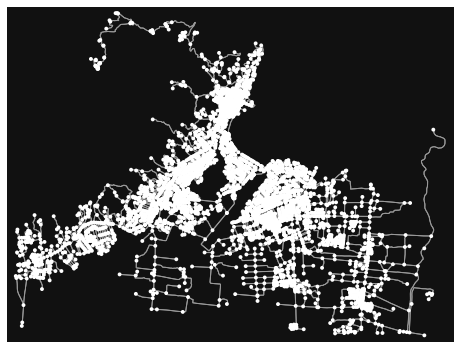

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [15]:
# Visually inspect (takes a minute or two)
ox.plot_graph(Gwalk)

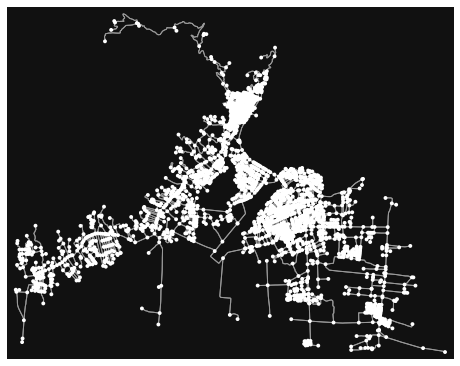

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
ox.plot_graph(Gdrive)

## Extract Ferries over AOI
Visited https://overpass-turbo.eu/ and manually ran a query for ferries (way["ferry"]) within Cap Haitien. Detected the only ferries near Pointe Labadie, so a bounding box was manually created in QGIS that covered all of the ferries.

In [17]:
# import extent
cap_haitien_extent = gpd.read_file("input_folder/cap_haitien_ferry_extent.shp")

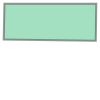

In [18]:
extent = cap_haitien_extent.geometry[0]
extent

In [19]:
walk_custom = '["ferry"]'

In [20]:
# Pull in the walk network with OSMNX
%time Gferries = ox.graph_from_polygon(extent, custom_filter=walk_custom)

Wall time: 845 ms


In [21]:
print(nx.info(Gferries))

Name: 
Type: MultiDiGraph
Number of nodes: 6
Number of edges: 10
Average in degree:   1.6667
Average out degree:   1.6667


In [22]:
Gferries

In [23]:
Gferries.edges

OutMultiEdgeView([(616085737, 6733460125, 0), (616085737, 6970559909, 0), (616085737, 2413706127, 0), (616085737, 2413706138, 0), (616085737, 3448749786, 0), (2413706127, 616085737, 0), (2413706138, 616085737, 0), (3448749786, 616085737, 0), (6733460125, 616085737, 0), (6970559909, 616085737, 0)])

In [24]:
# test
Gferries.edges[616085737, 6733460125,0]

{'osmid': 212397499,
 'ferry': 'unclassified',
 'oneway': False,
 'length': 8474.458,
 'geometry': <shapely.geometry.linestring.LineString at 0x1af983d84c0>}

In [25]:
Gferries.nodes

NodeView((616085737, 2413706127, 2413706138, 3448749786, 6733460125, 6970559909))

### Add ferry nodes and edges to the walking & driving graphs

In [26]:
# add each osm node to the graph
# even if the node already exists in the graph, it won't create duplicates
for node, data in Gferries.nodes.items():
    #print(node,data)
    Gwalk.add_node(node, **data)
    Gdrive.add_node(node, **data)

In [27]:
# add each osm edge to the graph
for edge, data in Gferries.edges.items():
    print(edge,data)
    Gwalk.add_edges_from([edge], **data)
    Gdrive.add_edges_from([edge], **data)

(616085737, 6733460125, 0) {'osmid': 212397499, 'ferry': 'unclassified', 'oneway': False, 'length': 8474.458, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF983D84C0>}
(616085737, 6970559909, 0) {'osmid': 214459218, 'ferry': 'unclassified', 'oneway': False, 'length': 1449.198, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF983D8340>}
(616085737, 2413706127, 0) {'osmid': 233037712, 'ferry': 'unclassified', 'oneway': False, 'length': 1186.217, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF983D84F0>}
(616085737, 2413706138, 0) {'osmid': 233037714, 'ferry': 'unclassified', 'oneway': False, 'length': 888.716, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF983D87F0>}
(616085737, 3448749786, 0) {'osmid': 337815403, 'ferry': 'unclassified', 'oneway': False, 'length': 1428.7089999999998, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF983D8700>}
(2413706127, 616085737, 0)

In [28]:
print(nx.info(Gwalk))

Name: 
Type: MultiDiGraph
Number of nodes: 4145
Number of edges: 11404
Average in degree:   2.7513
Average out degree:   2.7513


In [29]:
print(nx.info(Gdrive))

Name: 
Type: MultiDiGraph
Number of nodes: 2706
Number of edges: 7557
Average in degree:   2.7927
Average out degree:   2.7927


In [30]:
Gwalk.nodes[6770195160]

{'y': 19.7278721, 'x': -72.2057506, 'street_count': 4}

In [31]:
gn.example_edge(Gdrive, 10)

(330725194, 330736449, {'osmid': 30034450, 'name': 'Route usine', 'highway': 'unclassified', 'oneway': False, 'length': 1490.4389999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFECA0>})
(330725194, 628930680, {'osmid': 218402959, 'name': 'Route Boisdaut', 'highway': 'unclassified', 'oneway': False, 'length': 611.274, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFECD0>})
(330725194, 2313441588, {'osmid': [218402957, 30034598, 218402959], 'name': 'Route Boisdaut', 'highway': 'unclassified', 'oneway': False, 'length': 270.352, 'bridge': 'yes', 'geometry': <shapely.geometry.linestring.LineString object at 0x000001AF9ABFED00>})
(330725346, 614908804, {'osmid': 48413285, 'name': 'Rue 2', 'highway': 'unclassified', 'oneway': False, 'length': 43.592})
(330725346, 614908783, {'osmid': 48413285, 'name': 'Rue 2', 'highway': 'unclassified', 'oneway': False, 'length': 48.71})
(330725346, 2150615578, {'osmid': 50759615, 'name': 'Rue

In [32]:
# save again and inspect. 
# These outputs will also be used in step 3 to snap the destinations
gn.save(Gwalk,"clipped_cap_haitien_walk_w_ferries_via_osmnx",r"temp")
#gn.save(Gdrive,"clipped_cap_haitien_drive_w_ferries_via_osmnx",r"temp")

## You can re-start notebook from here 

In [33]:
# The Gwalk graph was intersected with flooded areas in another notebook
# so here we are re-importing it back in
Gwalk = nx.read_gpickle(r"temp/clipped_cap_haitien_walk_w_ferries_via_osmnx.pickle")
Gdrive = nx.read_gpickle(r"temp/clipped_cap_haitien_drive_w_ferries_via_osmnx.pickle")

In [34]:
# The Gwalk graph was intersected with flooded areas in another notebook and saved
# so here we are re-importing it back in
Gwalk_flooded = nx.read_gpickle(r"temp/flooded_clipped_cap_haitien_walk_w_ferries_via_osmnx.pickle")

## Advanced Snapping
Now we want to take our population grid vector points and use them to expand the graph. 

In [35]:
# load origins
origins = gpd.read_file(r"input_folder\nonflooded_cap_haitien_worldpop_pts2_clipped3.shp")

### Make the node_ID really high in order to not interfere with exisiting OSMIDs from the graph

In [36]:
origins['node_ID'] = 1110000000 + origins.index
origins

,VALUE,geometry,node_ID
0,7.042591,POINT (-72.24750 19.78750),1110000000
1,6.827713,POINT (-72.24667 19.78750),1110000001
2,14.694184,POINT (-72.24083 19.78750),1110000002
3,14.852985,POINT (-72.24000 19.78750),1110000003
4,5.294649,POINT (-72.23917 19.78750),1110000004
...,...,...,...
13470,5.979215,POINT (-72.13917 19.68750),1110013470
13471,5.988163,POINT (-72.13833 19.68750),1110013471
13472,5.949585,POINT (-72.13750 19.68750),1110013472
13473,6.206617,POINT (-72.13667 19.68750),1110013473


In [37]:
# find graph utm zone
G_utm = gn.utm_of_graph(Gwalk)
G_utm

'+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [38]:
# testing
# for edge, data in Gwalk.edges.items():
#     print(edge,data)

### This is the GOSTnets advanced_snap function. 

#### note on GOSTnets implementation detail:
As of now make sure node_key_col='node_ID' because gn.advanced_snap does node_gdf_from_graph(G) and node_gdf_from_graph has node_ID for the ID column

In [39]:
# example of nodes in Gwalk
gn.example_node(Gwalk,n=5)

(330725194, {'y': 19.71362, 'x': -72.175561, 'street_count': 4})
(330725346, {'y': 19.7546605, 'x': -72.204247, 'street_count': 4})
(330725641, {'y': 19.7628712, 'x': -72.1967104, 'street_count': 3})
(330726131, {'y': 19.7185951, 'x': -72.1990149, 'street_count': 3})
(330726263, {'y': 19.7287159, 'x': -72.1559022, 'street_count': 3})


### note that we are using a shorter threshold 

In [44]:
%%time
G2_walk, pois_meter_walk, new_footway_edges_walk = gn.advanced_snap(Gwalk, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='node_ID', poi_key_col='node_ID', threshold=150, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
print _new_nodes
Updating internal edges...
Updating external links...
print unvalid lines over threshold
                     node_ID  \
15715  9990000000_1110000000   
15716  9990000001_1110000001   
15722  9990000005_1110000007   
15723  9990000006_1110000008   
15724  9990000007_1110000009   
...                      ...   
29180  2342224594_1110013465   
29181  2293173919_1110013466   
29182  9990007535_1110013467   
29188  2331361664_1110013473   
29189  2331361664_1110013474   

                                                geometry  oneway  \
15715  LINESTRING (788396.410 2190312.738, 788508.901...   False   
15716  LINESTRING (788483.776 2190314.161, 788531.367...   False   
15722  LINESTRING (788310.546 2190219.020, 788407.752...   False   
15723  LINESTRING (788397.912 2190220.441, 788491.674...   False   
15724  LINESTRING (788485.278 2190221.863, 788524.659...   False   
...                   

In [45]:
%%time
G2_walk_flooded, pois_meter_walk_flooded, new_footway_edges_walk_flooded = gn.advanced_snap(Gwalk_flooded, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='node_ID', poi_key_col='node_ID', threshold=150, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
print _new_nodes
Updating internal edges...
Updating external links...
node count before: 23886
node count after: 17019
pois_meter count before: 13475
pois_meter count after: 6608
Remove edge projections greater than threshold: 6867/13475 (50.96%)
NOTE: duplication in node coordinates keys
Nodes count: 17019
Node coordinates key count: 23886
Missing 'from' nodes: 0
Missing 'to' nodes: 0
making a new graph from edges and nodes
Wall time: 29.8 s


In [46]:
%%time
G2drive, pois_meter_Gdrive, new_footway_edges_Gdrive = gn.advanced_snap(Gdrive, origins, u_tag = 'stnode', v_tag = 'endnode', node_key_col='node_ID', poi_key_col='node_ID', threshold=150, measure_crs=G_utm)

Building rtree...
Projecting POIs to the network...
Updating internal nodes...
print _new_nodes
Updating internal edges...
Updating external links...
node count before: 22409
node count after: 14438
pois_meter count before: 13475
pois_meter count after: 5504
Remove edge projections greater than threshold: 7971/13475 (59.15%)
NOTE: duplication in node coordinates keys
Nodes count: 14438
Node coordinates key count: 22409
Missing 'from' nodes: 0
Missing 'to' nodes: 0
making a new graph from edges and nodes
Wall time: 28.7 s


### Test the total length of new_footway_edges_walk vs new_footway_edges_walk_flooded

In [50]:
#pois_meter_walk

In [51]:
pois_meter_walk['VALUE'].sum()

289538.19838208996

In [52]:
pois_meter_walk_flooded['VALUE'].sum()

276763.91874169

### This difference represents the population that has access to the regular network vs the flooded network

In [57]:
pois_meter_walk['VALUE'].sum() - pois_meter_walk_flooded['VALUE'].sum()

12774.279640399967

### Save the advanced snapped graphs for Step 2

In [53]:
gn.save(G2_walk,"clipped4_cap_haitien_walk_w_ferries_via_osmnx_origins_adv_snap",r"temp")
gn.save(G2_walk_flooded,"flooded4_clipped_cap_haitien_drive_w_ferries_via_osmnx_origins_adv_snap",r"temp")
gn.save(G2drive,"clipped4_cap_haitien_drive_w_ferries_via_osmnx_origins_adv_snap",r"temp")

### The new_poi_nodes will be used for the origin nodes when calculating an OD matrix

In [54]:
new_poi_nodes2 = pois_meter_walk[['node_ID','VALUE','geometry']]

# save new_nodes
new_poi_nodes2.to_csv(r"temp/clipped_origin_nodes_walk4.csv")

In [55]:
new_poi_nodes2_flooded = pois_meter_walk_flooded[['node_ID','VALUE','geometry']]

# save new_nodes
new_poi_nodes2_flooded.to_csv(r"temp/flooded_clipped_origin_nodes_walk4.csv")

In [56]:
new_poi_nodes2_drive = pois_meter_Gdrive[['node_ID','VALUE','geometry']]
# save new_nodes
new_poi_nodes2_drive.to_csv(r"temp/clipped_origin_nodes_drive4.csv")

## Extra tests: Inspecting disconnected subgraphs

In [ ]:
# compatible with NetworkX 2.4
list_of_subgraphs = list(G2.subgraph(c).copy() for c in nx.weakly_connected_components(G2))
max_graph = None
max_edges = 0

# To sort the list in place...
list_of_subgraphs.sort(key=lambda x: x.number_of_edges(), reverse=True)


In [ ]:
for subgraph in list_of_subgraphs:
    print(len(subgraph))
    # to inspect
    gn.save(subgraph,f"{len(subgraph)}_inspect",r"temp", pickle = False, edges = True, nodes = False)